In [1]:
import pickle
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from utils_window import TimeSeriesScaler, f1_m, MIMIC_DATA_PATH
import matplotlib.pyplot as plt
import timeit

2023-03-09 23:09:38.699544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 23:09:38.972316: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-09 23:09:39.835402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-09 23:09:39.835484: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
feature_map_mimic = ['ANION GAP', 'ALBUMIN', 'BICARBONATE', 'BILIRUBIN', 
                     'CREATININE', 'CHLORIDE', 'GLUCOSE', 'HEMATOCRIT', 
                     'HEMOGLOBIN', 'LACTATE', 'MAGNESIUM', 'PHOSPHATE', 
                     'PLATELET', 'POTASSIUM', 'PTT',
                     'INR', 'PT', 'SODIUM', 'BUN', 'WBC', 'HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'SpO2','Temp', 'gender','age','ethnicity','first_icu_stay']
## len 31 - same as pkl file

In [3]:
# len(feature_map_mimic)

In [4]:
with (open('patient_vital_preprocessed.pkl', "rb")) as obj:
    mimic_data = pickle.load(obj)

In [5]:
value = np.zeros((len(mimic_data), mimic_data[0][0].shape[0], mimic_data[0][0].shape[1]))*np.nan
output = np.zeros(len(mimic_data))*np.nan
for i, data in enumerate(mimic_data):
    value[i] = data[0]
    output[i] = data[1]

In [6]:
value.shape

(22988, 31, 48)

In [7]:
print(feature_map_mimic) 

['ANION GAP', 'ALBUMIN', 'BICARBONATE', 'BILIRUBIN', 'CREATININE', 'CHLORIDE', 'GLUCOSE', 'HEMATOCRIT', 'HEMOGLOBIN', 'LACTATE', 'MAGNESIUM', 'PHOSPHATE', 'PLATELET', 'POTASSIUM', 'PTT', 'INR', 'PT', 'SODIUM', 'BUN', 'WBC', 'HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'SpO2', 'Temp', 'gender', 'age', 'ethnicity', 'first_icu_stay']


In [8]:
# ind  = 30
# plt.figure(figsize=(10, 8))
# for i in range(199):
#     y = value[i,ind,:]
#     x = np.arange(1, 49, 1)
#     plt.plot(x,y)
# # plt.plot(x,y1)
# plt.title(feature_map_mimic[ind],fontsize = 40)
# plt.show()

In [9]:
# Removing demographic features,(gender,age, ethinicity, first_icu_stay)
value = value[:,:-4,:]
value = np.transpose(value, axes=(0,2,1))
# Removing 8th feature since it is constant
value = np.delete(value, 8, axis=2)

In [11]:
value.shape, output.shape

((22988, 48, 26), (22988,))

In [12]:
np.savez('mimic3_all.npz', value, output)

In [29]:
# Splitting data
train_x, test_x, train_y, test_y= train_test_split(value, output,
                                                   test_size=0.2, random_state=4,
                                                   stratify=output)

# CV setting
# kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
# train_idx, test_idx = list(kf.split(X=value, y=output))[1]
# train_x, test_x = value[train_idx], value[test_idx]
# train_y, test_y = output[train_idx], output[test_idx]
    
# normalizing train and test set
train_scaler, test_scaler = TimeSeriesScaler(), TimeSeriesScaler()
train_x = train_scaler.fit_transform(train_x)
test_x = test_scaler.fit_transform(test_x)

In [30]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((18390, 16, 33), (4598, 16, 33), (18390,), (4598,))

In [27]:
###### so the new feature list is 

feature_map_mimic_26 = ['ANION GAP', 'ALBUMIN', 'BICARBONATE', 'BILIRUBIN','CREATININE', 'CHLORIDE', 'GLUCOSE', 'HEMATOCRIT', 
                     'LACTATE', 'MAGNESIUM', 'PHOSPHATE','PLATELET', 'POTASSIUM', 'PTT','INR', 'PT', 
                     'SODIUM', 'BUN', 'WBC', 'HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'SpO2','Temp']
## len 36 - same as size of train-test set features

In [31]:
np.savez('train_test_x_y_05.npz', train_x, test_x, train_y, test_y) ### next time directly load from here

In [7]:
### directly load train test matrix

data = np.load('train_test_x_y.npz')

In [8]:
train_x, test_x, train_y, test_y  = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] 

In [9]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((18390, 48, 26), (4598, 48, 26), (18390,), (4598,))

## Simple RNN Model

In [36]:
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, regularizers
from tensorflow.keras import backend as K
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, average_precision_score, matthews_corrcoef
from tensorflow import keras

In [16]:
es_patience = 100
learning_rate = 0.01
reg_rate = 0.01
epochs = 3000
bach_size = 64
droup_rate = 0.4

In [23]:
K.clear_session()

In [18]:
# Sample weights
sample_weights = np.ones(len(train_y))
sample_weights[train_y==0] = len(train_y)/(train_y==0).sum()
sample_weights[train_y==1] = len(train_y)/(train_y==1).sum()

In [26]:
model = Sequential()
# model.add(Input(shape=(value.shape[1], value.shape[2]))) #old
model.add(Input(shape=(train_x.shape[1], train_x.shape[2])))
model.add(GRU(70, activation='relu', dropout=0.3, recurrent_dropout=0.3))
model.add(Dropout(droup_rate))
model.add(Dense(40, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)))
model.add(Dropout(droup_rate))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)))
model.add(Dense(1, activation='sigmoid'))

# train the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=es_patience, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy',
              metrics=['accuracy', f1_m], weighted_metrics=[])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 70)                20580     
                                                                 
 dropout_2 (Dropout)         (None, 70)                0         
                                                                 
 dense_3 (Dense)             (None, 40)                2840      
                                                                 
 dropout_3 (Dropout)         (None, 40)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                410       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 23,841
Trainable params: 23,841
Non-trai

In [ ]:
train_history = model.fit(train_x, train_y, batch_size=bach_size,epochs=epochs, verbose=2,validation_split=0.2,
                          sample_weight=sample_weights,
                          callbacks=[es])

In [28]:
print(roc_auc_score(test_y, model.predict(test_x)))
print(average_precision_score(test_y, model.predict(test_x)))
print(f1_score(test_y, np.round(model.predict(test_x))))
print(recall_score(test_y, np.round(model.predict(test_x))))
print(precision_score(test_y, np.round(model.predict(test_x))))

144/144 [==============================] - 1s 3ms/step
0.786619517752041
144/144 [==============================] - 0s 3ms/step
0.360275775814469
144/144 [==============================] - 0s 3ms/step
0.3315565031982943
144/144 [==============================] - 0s 3ms/step
0.6790393013100436
144/144 [==============================] - 1s 3ms/step
0.21932299012693934


In [29]:
matthews_corrcoef(test_y, np.round(model.predict(test_x)))

144/144 [==============================] - 0s 3ms/step


0.2669360567499076

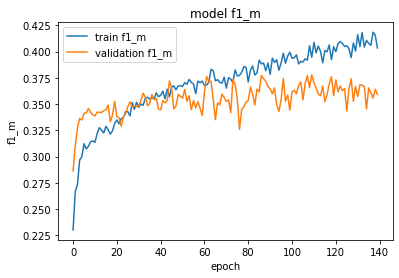

In [30]:
drop_items = 1
metric = 'f1_m'
plt.plot(train_history.history[metric][drop_items:])
plt.plot(train_history.history['val_' + metric][drop_items:])
plt.title('model ' + metric)
plt.ylabel(metric)
plt.xlabel('epoch')
# plt.ylim(0,3)
plt.legend(['train ' + metric, 'validation ' + metric], loc='upper left')
plt.show()

In [31]:
model.save('saved_model_GRU.h5')

In [39]:
model = keras.models.load_model('saved_model_GRU.h5', compile=False)

## SHAP interpretation

In [30]:
from windowshap import SlidingWindowSHAP, StationaryWindowSHAP, DynamicWindowSHAP

In [16]:
# ### from the synthetic_example.ipynb
# num_background = 50
# num_test = 28
# background_data, test_data = train_x[:num_background], test_x[num_test:num_test+2]


### from another notebook

num_background = 15
num_test = index = 0
# background_ts, test_ts = train_x[:num_background], test_x[index:index + 17]
background_data, test_data = train_x[:num_background], test_x[index:index + 17]

## 1- Stationary WindowSHAP

In [38]:
tic = timeit.default_timer()
ts_phi_1 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    window_len = 20
    gtw = StationaryWindowSHAP(model, window_len, B_ts=background_data, test_ts=test_data[i:i+1], model_type='lstm')
    ts_phi_1[i,:,:] = gtw.shap_values()
print('Total time: ' + str(timeit.default_timer()-tic))

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1034/1034 [==============================] - 3s 3ms/step
Total time: 1326.345303228998


## 2- Sliding WindowSHAP

In [39]:
tic = timeit.default_timer()
ts_phi_2 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    window_len = 20
    stride = 10
    gtw = SlidingWindowSHAP(model, stride, window_len, background_data, test_data[i:i+1], model_type='lstm')
    ts_phi_2[i,:,:] = gtw.shap_values()
print('Total time: ' + str(timeit.default_timer()-tic))

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

122/122 [==============================] - 0s 3ms/step
Total time: 224.26856674700684


## 3- Dynamic WindowSHAP

In [79]:
tic = timeit.default_timer()
ts_phi_3 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    delta = 0.01
    n_w = 20
    btw = DynamicWindowSHAP(model, delta, n_w, background_data, test_data[i:i+1], model_type='lstm')
    ts_phi_3[i,:,:] = btw.shap_values()
print('Total time: ' + str(timeit.default_timer()-tic))

1/1 [==============================] - 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1146/1146 [==============================] - 4s 4ms/step
Total time: 968.0934753539914


## some analysis

In [42]:
ts_phi_1.shape, ts_phi_2.shape, ts_phi_3.shape

((17, 48, 26), (17, 48, 26), (17, 48, 26))

In [44]:
# ts_phi_3

In [94]:
##### save the shaps

# np.save('ts_phi_1.npy',ts_phi_1)

In [95]:
# np.save('ts_phi_2.npy',ts_phi_2)

In [80]:
# np.save('ts_phi_3.npy',ts_phi_3)

In [10]:
from util import heat_map

In [65]:
# import importlib
# importlib.reload(util)

NameError: name 'util' is not defined

In [11]:
var = 15
phi_index = 0

## Heatmap for Stationary SHAP

In [13]:
# num_test = index
## load shap

ts_phi_1 = np.load('ts_phi_1.npy')
ts_phi_2 = np.load('ts_phi_2.npy')
ts_phi_3 = np.load('ts_phi_3.npy')

In [14]:

def heat_map(start, stop, x, shap_values, var_name='Feature 1', plot_type='bar', title=None):
    """
    A function that generates a heatmap with the temporal sequence alongside its Shapley values

    Parameters
    ----------
    start (int): the starting point of the temporal sequence
    stop (int): the ending point of the temporal sequence
    x (np.ndarray): the sequence data
    shap_values (np.ndarray): the Shapley values corresponding to the sequence data
    var_name (str): the name of the variable being plotted (default: 'Feature 1')
    plot_type (str): the type of plot to generate ('bar' or 'heat' or 'heat_abs', default: 'bar')
    title (str): the title for the plot (default: None)
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.colors import BoundaryNorm
    from textwrap import wrap
    import numpy as np; np.random.seed(1)
    
    ## ColorMap-------------------------
    # define the colormap
    cmap = plt.get_cmap('PuOr_r')

    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize and forcing 0 to be part of the colorbar!
    bounds = np.arange(np.min(shap_values),np.max(shap_values),.001)
    idx=np.searchsorted(bounds,0)
    bounds=np.insert(bounds,idx,0)
    print(bounds)
    norm = BoundaryNorm(bounds, cmap.N)
    
    ##------------------------------------
    
    if title is None: title = '\n'.join(wrap('{} values and contribution scores'.format(var_name), width=40))
    
    if plot_type=='heat' or plot_type=='heat_abs':
        plt.rcParams["figure.figsize"] = 9,3
        if plot_type=='heat_abs':
            shap_values = np.absolute(shap_values)
            cmap = 'Reds'
        fig, ax1 = plt.subplots(sharex=True)
        extent = [start, stop, -2, 2]
        im1 = ax1.imshow(shap_values[np.newaxis, :], cmap=cmap, norm=norm, aspect="auto", extent=extent)
        ax1.set_yticks([])
        ax1.set_xlim(extent[0], extent[1])
        ax1.title.set_text(title)
        fig.colorbar(im1, ax=ax1, pad=0.1)
        ax2 = ax1.twinx()
        ax2.plot(np.arange(start, stop), x, color='black')
    elif plot_type=='bar':
        plt.rcParams["figure.figsize"] = 8.5,2.5
        fig, ax1 = plt.subplots(sharex=True)
        mask1 = shap_values < 0
        mask2 = shap_values >= 0
        ax1.bar(np.arange(start, stop)[mask1], shap_values[mask1], color='blue', label='Negative Shapley values')
        ax1.bar(np.arange(start, stop)[mask2], shap_values[mask2], color='red', label='Positive Shapley values')
        ax1.set_title(title)
        ax2 = ax1.twinx()
        ax2.plot(np.arange(start, stop), x, 'k-', label='Observed data')
        # legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        # ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    ax1.set_xlabel('Time steps')
    if plot_type=='bar': ax1.set_ylabel('Shapley values')
    ax2.set_ylabel(var_name + ' data values')
    plt.tight_layout()
    plt.show()

In [18]:
var = 1
phi_index = 3

[0.         0.00034277]


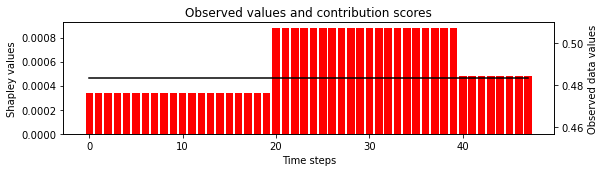

In [19]:
heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_1[phi_index, :, var], var_name='Observed', plot_type='bar')

## Heatmap for Sliding SHAP

[0.         0.00609059 0.00709059 0.00809059 0.00909059 0.01009059
 0.01109059 0.01209059 0.01309059 0.01409059 0.01509059 0.01609059
 0.01709059 0.01809059 0.01909059 0.02009059 0.02109059 0.02209059
 0.02309059 0.02409059 0.02509059]


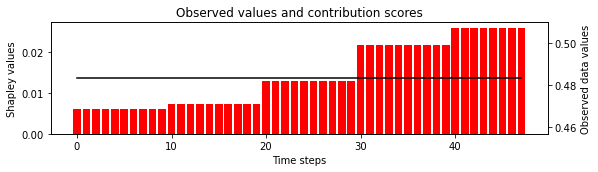

In [21]:
heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_2[phi_index, :, var], var_name='Observed', plot_type='bar')

## Heatmap for Dynamic SHAP

In [22]:
var = 5
phi_index = 3

[0.    0.    0.001]


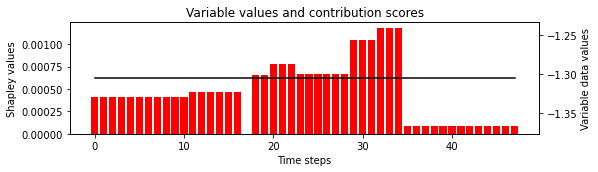

In [23]:
heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_3[phi_index, :, var], var_name='Variable', plot_type='bar')